### This notebook demonstrates how to set up a single run for uniform fuels

In [15]:
from __future__ import annotations

from typing import Dict, Tuple

# ============================================================
# CURING TABLE (same as yours)
# ============================================================
CURING_DEFAULT = {
    "early_spring_before_greenup": (1.00, 0.40),
    "spring_after_greenup":        (0.20, 0.10),
    "early_summer_senescence":     (0.60, 0.20),
    "fall_without_greenup":        (1.00, 0.50),
    "fall_with_greenup":           (0.80, 0.40),
    "Test": (0.90, 0.55)
}

# Fixed numeric ordering (explicit = reproducible)
# season_id:
#   0 = early_spring_before_greenup
#   1 = spring_after_greenup
#   2 = early_summer_senescence
#   3 = fall_without_greenup
#   4 = fall_with_greenup
CURING_INDEX = [
    "early_spring_before_greenup",
    "spring_after_greenup",
    "early_summer_senescence",
    "fall_without_greenup",
    "fall_with_greenup",
    "Test"
]


def curing_from_season_id(season_id: int) -> Tuple[float, float]:
    if not isinstance(season_id, int):
        raise TypeError(f"season_id must be int, got {type(season_id)}")

    if season_id < 0 or season_id >= len(CURING_INDEX):
        raise ValueError(
            f"Invalid season_id={season_id}. Must be in [0, {len(CURING_INDEX)-1}]"
        )

    key = CURING_INDEX[season_id]
    return CURING_DEFAULT[key]


# ============================================================
# UNIT CONVERSIONS
# ============================================================
TON_PER_ACRE_TO_KG_PER_M2 = 0.2241702312
FT_TO_M = 0.3048


# ============================================================
# CORE: fuel dict + season_id -> bulk density + depth
# ============================================================
def fuel_dict_to_density_and_depth(
    fuel_model: Dict,
    season_id: int,
) -> Tuple[float, float]:
    """
    Inputs:
      fuel_model dict keys required:
        - L1h_ton_ac, Lherb_ton_ac, Lwoody_ton_ac, depth_ft
      season_id:
        0..4 selects curing tuple (c_h, c_w)

    Returns:
      (rho_bulk_kg_m3, depth_m)
    """
    required = ["L1h_ton_ac", "Lherb_ton_ac", "Lwoody_ton_ac", "depth_ft"]
    missing = [k for k in required if k not in fuel_model]
    if missing:
        raise KeyError(f"Fuel model missing keys: {missing}. Got keys={sorted(fuel_model.keys())}")

    c_h, c_w = curing_from_season_id(season_id)

    # effective load in ton/acre
    L_eff_ton_ac = (
        float(fuel_model["L1h_ton_ac"])
        + float(c_h) * float(fuel_model["Lherb_ton_ac"])
        + float(c_w) * float(fuel_model["Lwoody_ton_ac"])
    )

    # depth in meters
    depth_m = float(fuel_model["depth_ft"]) * FT_TO_M

    # convert load to kg/m^2 then bulk density to kg/m^3
    w_eff_kg_m2 = L_eff_ton_ac * TON_PER_ACRE_TO_KG_PER_M2
    #rho_bulk = w_eff_kg_m2 / max(depth_m, 1e-12)

    return float(w_eff_kg_m2), float(depth_m)


# ============================================================
# OPTIONAL: pretty helper to print chosen curing name too
# ============================================================
def season_name_from_id(season_id: int) -> str:
    _ = curing_from_season_id(season_id)  # validates
    return CURING_INDEX[season_id]


# ============================================================
# EXAMPLE USAGE
# ============================================================
if __name__ == "__main__":
    GS2 = {
        "name": "GS2",
        "L1h_ton_ac": 0.50,
        "Lherb_ton_ac": 0.60,
        "Lwoody_ton_ac": 1.00,
        "depth_ft": 1.5,
        "SAV_dead_1ft": 2000.0,  # ignored here
    }

    SH2 = {"name": "GS2",
        "L1h_ton_ac": 1.35,
        "Lherb_ton_ac": 0.00,
        "Lwoody_ton_ac": 3.85,
        "depth_ft": 1.0,
        "SAV_dead_1ft": 2000.0,  # ignored here
    }

    # pick season by number
    season_id = 5  # early_summer_senescence

    rho, depth = fuel_dict_to_density_and_depth(SH2, season_id=season_id)

    print(f"Fuel: {GS2.get('name','(unnamed)')}")
    print(f"Season {season_id}: {season_name_from_id(season_id)}  curing={curing_from_season_id(season_id)}")
    print(f"Bulk density: {rho:.6f} kg/m^2")
    print(f"Fuel depth:   {depth:.4f} m")


Fuel: GS2
Season 5: Test  curing=(0.9, 0.55)
Bulk density: 0.777310 kg/m^2
Fuel depth:   0.3048 m


In [16]:
import sys

import json
import time

import numpy as np
import matplotlib.pyplot as plt
import IPython

import bp3d

In [17]:
import os

BP3D_URL = os.environ.get("BP3D_URL", "https://burnpro3d.sdsc.edu/api")
BP3D_USER = os.environ.get("BP3D_USER", "")
BP3D_PASS = os.environ.get("BP3D_PASS", "")

client = bp3d.Client(url=BP3D_URL, user=BP3D_USER, password=BP3D_PASS)


Add burn unit. Instead of uploading a shapefile, specify the uniform fuels parameters.

In [18]:
client.add_burn_units(name = 'SH2_C',
                      uniform={
                        'xlen': 200,
                        'ylen': 200,
                        'density': rho,
                        'height': depth
                      })

# client.add_burn_units(name = 'Testing_Uniform_02',
#                       uniform={
#                         'xlen': 200,
#                         'ylen': 200,
#                         'fuel_model': 'GS2',
#                         'curing_herb': 1,
#                         'curing_wood': 1
#                       })

,xlen,ylen,density,height,unit_id,name
1,200,200,0.77731,0.3048,2084b1b0-8d46-4cd5-863a-cdb80c47c272,SH2_C


List burn units to see that the uniform fuels unit was created

In [19]:
client.burn_units

['Auburn_0513',
 'Auburn_0514',
 'Auburn_0515',
 'Auburn_0516',
 'Auburn_0516f',
 'Auburn_0517',
 'Auburn_0520',
 'Auburn_0520_360',
 'Auburn_0602_360',
 'Big Trees Leticia',
 'CW_B1',
 'Cowles Mountain',
 'D. L. Bliss State Park',
 'File_1',
 'GEISEL',
 'GS2',
 'GS2_A',
 'GS2_s0_strip_fast',
 'Hills',
 'Independence Lake',
 'Jennifer st',
 'LA',
 'NLFTD Treatment Units North of Hwy 431',
 'New_real_world',
 'PB',
 'Pacific union college',
 'QFGUI project UCSD 2025-07-29 Ensemble burn area',
 'QFGUI project UCSD 2025-07-29 Ensemble burn area',
 'QFGUI project UCSD 2025-07-29 Ensemble burn area',
 'QFGUI project UCSD 2025-07-29 Ensemble burn area',
 'QFGUI project UCSD_v2 2025-07-30 Ensemble burn area',
 'QFGUI project UCSD_v2 2025-07-30 Ensemble burn area',
 'QFGUI project feb_02_2026 burn area',
 'QFGUI project feb_02_2026 burn area',
 'QFGUI project feb_02_2026_b burn area',
 'QFGUI project feb_03_2026 burn area',
 'QFGUI project feb_03_2026_b burn area',
 'QFGUI project feb_03_2026_

Burn units with uniform fuels can be retrieved using burn_unit_uniform()

In [20]:
uniform_unit = client.burn_unit_uniform('SH2_C')
uniform_unit

,id,name,xlen,ylen,dx,dy,density,height,fuel_model,curing_live_herbaceous,curing_live_woody,patch,gap
1,03780bc7-1da9-4c03-a4e1-23beccc282ce,SH2_C,200,200,2,2,0.77731,0.3048,None,25,10,None,None


Create a plan. A plan consists of one or more ensembles for a burn unit

In [21]:
plan = client.add_plan('SH2_feb17A', uniform_unit)

In [22]:
plan = client.plan('SH2_feb17A')

Add a new ensemble

Add a uniform fuel.

Add ignition pattern

Create the runs. The runs must use fuel(s) and ignition(s) created in this ensemble.
- Wind speed is m/s
- Surface and canopy moisture are percentages.
- **sim_time must be specified with uniform fuels.**

In [23]:
ens = plan.add_ensemble("SH2_feb17A")

fuel = ens.add_fuel(
    ftype="uniform",
    uniform={
        "loading": rho,   # <-- use your values
        "depth": depth      # <-- use your values
    }
)

# fuel = ens.add_fuel(
#     ftype="uniform",
#     uniform={
#             'xlen': 200,
#             'ylen': 200,
#             'fuel_model': 'GS2',
#             'curing_herb': 1,
#             'curing_wood': 1
#             }
# )

ign = ens.add_ignition(
    name="strip_1",
    firing_technique="strip",
    firing_direction=0,
    ignitors=1,
    gap_length=5,
    dash_length=10,
    velocity_mph= 2.0,
    metric=True,
    replace=True,
)

ens.add_runs(
    fuel=fuel,
    ignition=ign,
    wind_speed= [5],
    wind_speed_units="mph",
    wind_direction= [90],
    surface_moisture= 0.04,
    uniform={
        "xlen": 200, "ylen": 200,
        "dx": 2, "dy": 2,
        "density": rho, "height": depth
    },
    topo={
        "topo_calcs": False,         # <- turn off topo calcs
         },

    sim_time = 600,

    output={
        "fuels_dens": True,          # you already had this True
        "energy_atmos": True,        # you already had this True
        "steps_fire": 60,            # <-- was 600; now every 60s
        "steps_wind": 60,           # leave unless you also want wind outputs
        "steps_avg_wind": 60,
        "steps_avg_emissions_radiation": 60,

        # keep the rest as you like
        "wind": True,
        "qu_wind": False,
        "qu_avg_wind": False,
        "fuels_moist": True,
        "reaction_rate": True,
        "thermal_rad": False,
        "fire_energy": True,
        "vert_mass_burnt": False,
        "plume_locs": False,
        "plume_traj": False,
        "emissions": True,
    },
    replace=True
)

# ens.add_runs(
#     fuel=fuel,
#     ignition=ign,
#     wind_speed= [5],
#     wind_speed_units="mph",
#     wind_direction= [90],
#     surface_moisture= 0.04,
#     uniform={
#             'xlen': 200,
#             'ylen': 200,
#             'fuel_model': 'GS2',
#             'curing_herb': 1,
#             'curing_wood': 1
#             },
#     topo={
#         "topo_calcs": False,         # <- turn off topo calcs
#          },
#
#     sim_time = 300,
#
#     output={
#         "fuels_dens": True,          # you already had this True
#         "energy_atmos": True,        # you already had this True
#         "steps_fire": 60,            # <-- was 600; now every 60s
#         "steps_wind": 60,           # leave unless you also want wind outputs
#         "steps_avg_wind": 60,
#         "steps_avg_emissions_radiation": 60,
#
#         # keep the rest as you like
#         "wind": True,
#         "qu_wind": False,
#         "qu_avg_wind": False,
#         "fuels_moist": True,
#         "reaction_rate": True,
#         "thermal_rad": False,
#         "fire_energy": True,
#         "vert_mass_burnt": False,
#         "plume_locs": False,
#         "plume_traj": False,
#         "emissions": True,
#     },
#     replace=True
# )





creating FastFuels.


In [24]:
ens.runs_df

,status,percent_done,viz,viz_running,metrics,ignition_parameters,ignition_elapsed_time,objectives,dz,seed,...,canopy_moisture,partial_outputs,number_ignitions,quicfire_version,surface_moisture,wind_speed_units,wind_height_units,fuel_id,ignition_id,latest_viz
run_id,,,,,,,,,,,,,,,,,,,,,
c381e06c-e2b7-4f82-a302-4aa4140cd6ec,draft,0,None,None,None,None,3546,None,None,222,...,None,True,2,6.1.2-dist,0.04,mph,meters,d7eb539e-c076-45f3-b7a5-d5e9506fe31b,86e29c66-d40f-444a-86b7-575a8f568157,[]


Start the model. **NOTE: once execution starts, the ensemble cannot be changed.**

In [25]:
ens.execute()

The status is automatically updated in the dataframe

In [12]:
import time
from collections import Counter

TERMINAL = {
    "completed", "complete", "succeeded", "success", "finished", "done",
    "failed", "error", "cancelled", "canceled", "fail"
}
ACTIVE = {"queued", "pending", "running", "starting", "submitted", "writing ouputs", "postprocessing", 'calculating winds', 'creating inputs'}

def wait_for_runs(ensemble, poll_sec=15, max_idle_polls=40):
    """
    Wait until all runs reach a terminal state.
    - Works even if backend uses different status strings.
    - Prints status counts + unique states.
    - Stops if nothing changes for max_idle_polls polls (to avoid infinite loops).
    """
    last_states = None
    idle_polls = 0

    while True:
        ensemble._update()
        runs = ensemble._ensemble.get("runs", [])

        # Normalize statuses: lowercase strings, turn None into "unknown"
        states = []
        for r in runs:
            s = r.get("status")
            s = (s or "unknown")
            if isinstance(s, str):
                s = s.strip().lower()
            else:
                s = "unknown"
            states.append(s)

        counts = Counter(states)
        uniq = sorted(counts.keys())

        print("Run status counts:", dict(counts))
        # If you want the full per-run list (can be long), uncomment:
        # print("Run states:", states)

        # Detect no progress / stuck
        if last_states == states:
            idle_polls += 1
        else:
            idle_polls = 0
        last_states = states

        if idle_polls >= max_idle_polls:
            print(f"Stopping: no status change for {idle_polls} polls (~{idle_polls*poll_sec}s).")
            print("Unique statuses seen:", uniq)
            return runs

        # Terminal check: every run is in TERMINAL
        if runs and all(s in TERMINAL for s in states):
            print("All runs reached terminal states.")
            return runs

        # Helpful hint if statuses are weird
        if any(s not in TERMINAL and s not in ACTIVE and s != "unknown" for s in states):
            weird = sorted({s for s in states if s not in TERMINAL and s not in ACTIVE and s != "unknown"})
            print("Note: unexpected non-terminal statuses:", weird)

        time.sleep(poll_sec)

# usage
runs_final = wait_for_runs(ens, poll_sec=15, max_idle_polls=40)


Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {'starting': 1}
Run status counts: {

When the run finishes, postprocessing creates viz and metrics

In [40]:
ens.runs_df

,status,percent_done,viz,viz_running,metrics,ignition_parameters,ignition_elapsed_time,objectives,dz,seed,...,canopy_moisture,partial_outputs,number_ignitions,quicfire_version,surface_moisture,wind_speed_units,wind_height_units,fuel_id,ignition_id,latest_viz
run_id,,,,,,,,,,,,,,,,,,,,,
c381e06c-e2b7-4f82-a302-4aa4140cd6ec,done,100,[https://wifire-data.sdsc.edu/data/burnpro3d/d...,[],{'surface_consumption': 0.10581891983747482},None,3546,None,None,222,...,None,True,2,6.1.2-dist,0.04,mph,meters,d7eb539e-c076-45f3-b7a5-d5e9506fe31b,86e29c66-d40f-444a-86b7-575a8f568157,None


The outputs are written to a zarr file

In [41]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List

import numpy as np
import fsspec
import zarr
import matplotlib.pyplot as plt


# ============================================================
# CONFIG
# ============================================================

# Output root: one folder per run
import os

PERSIST = Path(os.environ.get("NDP_PERSIST", "/home/jovyan/_User-Persistent-Storage_"))
OUT_ROOT = PERSIST / "Paper_4" / "Outputs" / "feb_17_2026"
OUT_ROOT.mkdir(parents=True, exist_ok=True)
# Plot settings
PLOT = True
PLOT_ALL_VARIABLES = True          # plot every numeric array that can be sliced to 2D
PLOT_ALL_TIMESTEPS = True          # plot every timestep for time-varying arrays
Z_LEVEL = 0                        # used for arrays with a z dimension
FLIP_UD = True
DPI = 150

# Download settings
DOWNLOAD = True
SAVE_NPY = True                    # save arrays as .npy
SAVE_ARRAY_MANIFEST = True         # save dtype/shape/chunks per array


# ============================================================
# Helper: extract all runs robustly
# ============================================================

def extract_runs(qf_ensemble) -> List[Dict[str, Any]]:
    # If it's the BP3D Ensemble object
    if hasattr(qf_ensemble, "_update"):
        qf_ensemble._update()
        ens_dict = qf_ensemble._ensemble
    # If it's already a dict
    elif isinstance(qf_ensemble, dict):
        ens_dict = qf_ensemble
    else:
        raise TypeError("Unsupported ensemble type")

    runs: List[Dict[str, Any]] = []

    def walk(obj):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == "runs" and isinstance(v, list):
                    for r in v:
                        if isinstance(r, dict):
                            runs.append(r)
                else:
                    walk(v)
        elif isinstance(obj, list):
            for item in obj:
                walk(item)

    walk(ens_dict)

    # dedupe by run_uuid
    uniq: Dict[str, Dict[str, Any]] = {}
    for r in runs:
        ru = r.get("run_uuid")
        if ru:
            uniq[ru] = r

    return list(uniq.values())


# ============================================================
# Zarr URL builder
# ============================================================

BP3D_DATA_BASE = "https://wifire-data.sdsc.edu/data/burnpro3d"

def run_uuid_to_subdirs(run_uuid: str):
    compact = run_uuid.replace("-", "").lower()
    return compact[:2], compact[2:4]

def make_zarr_url(run_uuid: str):
    a, b = run_uuid_to_subdirs(run_uuid)
    return f"{BP3D_DATA_BASE}/d/{a}/{b}/run_{run_uuid}/quicfire.zarr"


# ============================================================
# Zarr open
# ============================================================

def open_zarr(url: str):
    mapper = fsspec.get_mapper(url)
    try:
        return zarr.open_consolidated(mapper, mode="r")
    except Exception:
        return zarr.open_group(mapper, mode="r")


# ============================================================
# Plot helpers
# ============================================================

def safe_key_to_filename(key: str) -> str:
    # Windows-safe (also handles nested group paths if any)
    return key.replace("/", "__").replace("\\", "__").replace(":", "__")

def infer_layout(shape):
    """
    How to slice to a 2D frame:
      - () -> scalar
      - (y, x) -> yx
      - (a, y, x) -> ayx  (a could be t or z)
      - (t, z, y, x) -> tzyx
    """
    if shape == ():
        return "scalar"
    if len(shape) == 2:
        return "yx"
    if len(shape) == 3:
        return "ayx"
    if len(shape) == 4:
        return "tzyx"
    return "other"

def is_numeric_array(arr) -> bool:
    try:
        return np.issubdtype(arr.dtype, np.number)
    except Exception:
        return False

def count_timesteps(arr) -> int:
    shp = arr.shape
    layout = infer_layout(shp)
    if layout == "tzyx":
        return shp[0]
    if layout == "ayx":
        # if first axis looks like time (more than 2), treat it as time; else not time-varying
        return shp[0] if shp[0] > 2 else 1
    return 1

def get_2d_frame(arr, t_idx: int, zlev: int) -> np.ndarray:
    shp = arr.shape
    layout = infer_layout(shp)

    if layout == "yx":
        return np.asarray(arr[:, :])

    if layout == "ayx":
        # treat axis0 as time-like if >2, else as z-like
        if shp[0] > 2:
            return np.asarray(arr[t_idx, :, :])
        else:
            return np.asarray(arr[zlev, :, :])

    if layout == "tzyx":
        return np.asarray(arr[t_idx, zlev, :, :])

    raise ValueError(f"Cannot slice array of shape {shp} into 2D safely.")

def plot_all_timesteps_for_key(arr, key: str, plot_key_dir: Path, zlev: int, flipud: bool, dpi: int):
    nt = count_timesteps(arr)
    t_idxs = list(range(nt))  # ALL timesteps

    # global vmin/vmax across all timesteps (prevents flicker)
    vmin, vmax = None, None
    for t in t_idxs:
        img = get_2d_frame(arr, t, zlev)
        mn = float(np.nanmin(img))
        mx = float(np.nanmax(img))
        vmin = mn if vmin is None else min(vmin, mn)
        vmax = mx if vmax is None else max(vmax, mx)

    for t in t_idxs:
        img = get_2d_frame(arr, t, zlev)
        if flipud:
            img = np.flipud(img)

        plt.figure()
        plt.imshow(img, vmin=vmin, vmax=vmax)
        plt.title(f"{key} | t={t}/{max(nt-1,0)}")
        plt.colorbar()
        plt.tight_layout()

        fn = plot_key_dir / f"{safe_key_to_filename(key)}_t{t:04d}.png"
        plt.savefig(fn, dpi=dpi)
        plt.close()


# ============================================================
# Main exporter
# ============================================================

def export_all_runs(qf_ensemble):
    runs = extract_runs(qf_ensemble)
    print(f"\nFound {len(runs)} run(s)")

    for r in runs:
        run_uuid = r.get("run_uuid")
        if not run_uuid:
            continue

        print("\n====================================")
        print("Processing run:", run_uuid)

        run_folder = OUT_ROOT / f"run_{run_uuid}"
        run_folder.mkdir(parents=True, exist_ok=True)

        arrays_folder = run_folder / "arrays"
        arrays_folder.mkdir(parents=True, exist_ok=True)

        plots_folder = run_folder / "plots"
        plots_folder.mkdir(parents=True, exist_ok=True)

        # ---- save inputs + metrics ----
        params = r.get("parameters", {})
        with open(run_folder / "inputs.json", "w") as f:
            json.dump(params, f, indent=2)

        metrics = r.get("metrics", {})
        with open(run_folder / "metrics.json", "w") as f:
            json.dump(metrics, f, indent=2)

        # ---- open zarr ----
        zarr_url = make_zarr_url(run_uuid)
        print("Zarr URL:", zarr_url)

        try:
            z = open_zarr(zarr_url)
        except Exception as e:
            print("Failed to open Zarr:", e)
            continue

        keys = list(z.array_keys())
        print("Found arrays:", keys)

        # ---- manifest ----
        manifest: Dict[str, Any] = {}

        # ---- iterate arrays ----
        for key in keys:
            arr = z[key]

            # record metadata
            try:
                manifest[key] = {
                    "shape": tuple(arr.shape) if getattr(arr, "shape", None) is not None else None,
                    "dtype": str(arr.dtype) if getattr(arr, "dtype", None) is not None else None,
                    "chunks": getattr(arr, "chunks", None),
                    "compressor": str(getattr(arr, "compressor", None)),
                }
            except Exception:
                manifest[key] = {"shape": None, "dtype": None}

            # -------------- DOWNLOAD --------------
            if DOWNLOAD:
                print("Downloading:", key)
                out_base = arrays_folder / safe_key_to_filename(key)

                try:
                    if getattr(arr, "shape", None) == ():
                        val = arr[()]
                        # try numeric save else json
                        try:
                            np.save(str(out_base) + ".npy", np.asarray(val))
                        except Exception:
                            with open(str(out_base) + ".json", "w") as f:
                                json.dump(val, f, indent=2, default=str)
                    else:
                        if SAVE_NPY:
                            np.save(str(out_base) + ".npy", np.asarray(arr[:]))
                except Exception as e:
                    print("  (download failed)", key, "->", e)

            # -------------- PLOT --------------
            if PLOT:
                if not is_numeric_array(arr):
                    continue
                if getattr(arr, "shape", None) in [(), None]:
                    continue
                if len(arr.shape) < 2:
                    continue

                plot_key_dir = plots_folder / safe_key_to_filename(key)
                plot_key_dir.mkdir(parents=True, exist_ok=True)

                try:
                    print("Plotting:", key, "shape=", arr.shape, "dtype=", arr.dtype)
                    plot_all_timesteps_for_key(
                        arr,
                        key=key,
                        plot_key_dir=plot_key_dir,
                        zlev=Z_LEVEL,
                        flipud=FLIP_UD,
                        dpi=DPI,
                    )
                except Exception as e:
                    print("  (skip plot)", key, "->", e)

        if SAVE_ARRAY_MANIFEST:
            with open(run_folder / "arrays_manifest.json", "w") as f:
                json.dump(manifest, f, indent=2)

        print("Done run:", run_uuid)

    print("\nALL RUNS EXPORTED.")
    print("Saved to:", OUT_ROOT)


# ============================================================
# CALL
# ============================================================

export_all_runs(ens)



Found 1 run(s)

Processing run: c381e06c-e2b7-4f82-a302-4aa4140cd6ec
Zarr URL: https://wifire-data.sdsc.edu/data/burnpro3d/d/c3/81/run_c381e06c-e2b7-4f82-a302-4aa4140cd6ec/quicfire.zarr
Found arrays: ['co_emissions', 'emissions_distribution', 'fire-energy_to_atmos', 'fire-reaction_rate', 'fuels-dens', 'fuels-moist', 'pm_emissions', 'spatial_ref', 'topography', 'water_emissions', 'windu', 'windv', 'windw']
Downloading: co_emissions
Plotting: co_emissions shape= (11, 1, 100, 100) dtype= float16
Downloading: emissions_distribution
Plotting: emissions_distribution shape= (11, 1, 100, 100) dtype= float16
Downloading: fire-energy_to_atmos
Plotting: fire-energy_to_atmos shape= (11, 1, 100, 100) dtype= float16
Downloading: fire-reaction_rate
Plotting: fire-reaction_rate shape= (11, 1, 100, 100) dtype= float16
Downloading: fuels-dens
Plotting: fuels-dens shape= (11, 1, 100, 100) dtype= float16
Downloading: fuels-moist
Plotting: fuels-moist shape= (11, 1, 100, 100) dtype= float16
Downloading: p

png at https://wifire-data.sdsc.edu/data/burnpro3d/d/35/dc/run_35dc2411-35d4-493f-98cc-8d93d039c0ff/png/run_35dc2411-35d4-493f-98cc-8d93d039c0ff_fuels-dens_120_000.png


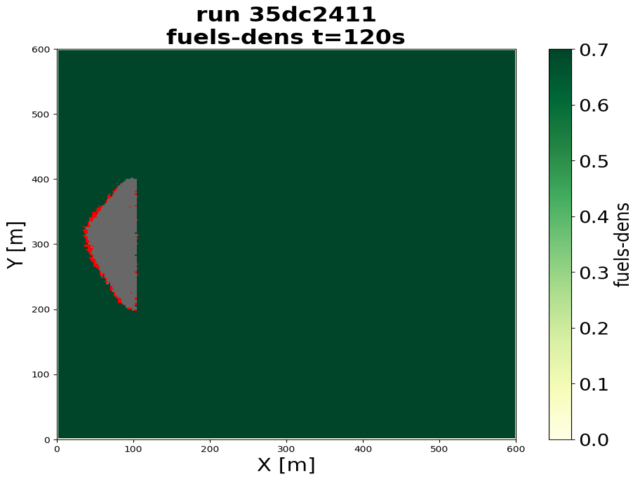

In [33]:
# display fuel density for last timestep
out = run.viz('png', 'fuels-dens', depth=0, timestep=z['fuels-dens'].shape[0]-1)
IPython.display.Image(out[0], width = 250)

In [ ]:
"""
PHASE 1 (restart-proof): One wrapper call builds ONE burn unit + ONE ensemble,
submits 16 runs = (4 wind speeds × 4 fuel moistures), waits, and exports results.

Folder structure:
OUT_ROOT/
  <burn_unit_name>/                         # e.g., GS2_s0_strip_fast
    run_ledger.json                         # restart ledger (run_uuid + zarr_url + export status)
    wind_<ws>__moist_<m>/                   # one per combo
      inputs.json
      metrics.json
      arrays_manifest.json
      arrays/*.npy                          # optional
      plots/<var>/<var>_tXXXX.png           # optional

Notes:
- DO NOT hardcode credentials. Use env vars: BP3D_USER, BP3D_PASS
- This is designed to be safely re-run after crashes: it detects what's done on disk.
"""

from __future__ import annotations

import json
import os
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import fsspec
import zarr

import bp3d


# =============================================================================
# 0) CONFIG (edit these defaults)
# =============================================================================

BP3D_URL = os.environ.get("BP3D_URL", "https://burnpro3d.sdsc.edu/api")
BP3D_USER = os.environ.get("BP3D_USER", "")
BP3D_PASS = os.environ.get("BP3D_PASS", "")
if not BP3D_USER or not BP3D_PASS:
    raise RuntimeError(
        "Set credentials via environment variables:\n"
        "  set BP3D_USER=...\n"
        "  set BP3D_PASS=...\n"
        "Do NOT hardcode passwords in notebooks."
    )

# output root
PERSIST = Path(os.environ.get("NDP_PERSIST", "/home/jovyan/_User-Persistent-Storage_"))
OUT_ROOT = PERSIST / "Paper_4" / "Outputs" / "phase1_runs"
OUT_ROOT.mkdir(parents=True, exist_ok=True)
# common domain settings (keep constant per your note)
UNIFORM_DOMAIN = dict(xlen=200, ylen=200, dx=2, dy=2)

# run settings (mostly constant)
WIND_DIRECTION_DEG = 90
WIND_SPEED_UNITS = "mph"     # you used mph
SIM_TIME_S = 3600

# exporter controls
DOWNLOAD = True
SAVE_NPY = True
PLOT = True
Z_LEVEL = 0
FLIP_UD = True
DPI = 150

# polling controls (long runs)
POLL_SEC = 60
MAX_WAIT_HOURS = 2.5   # set > 1 hour to be safe


# =============================================================================
# 1) FUEL MODEL + CURING (your logic)
# =============================================================================

CURING_DEFAULT = {
    "early_spring_before_greenup": (1.00, 0.40),
    "spring_after_greenup":        (0.20, 0.10),
    "early_summer_senescence":     (0.60, 0.20),
    "fall_without_greenup":        (1.00, 0.50),
    "fall_with_greenup":           (0.80, 0.40),
}

CURING_INDEX = [
    "early_spring_before_greenup",
    "spring_after_greenup",
    "early_summer_senescence",
    "fall_without_greenup",
    "fall_with_greenup",
]

TON_PER_ACRE_TO_KG_PER_M2 = 0.2241702312
FT_TO_M = 0.3048

def curing_from_season_id(season_id: int) -> Tuple[float, float]:
    if not isinstance(season_id, int):
        raise TypeError(f"season_id must be int, got {type(season_id)}")
    if season_id < 0 or season_id >= len(CURING_INDEX):
        raise ValueError(f"Invalid season_id={season_id}. Must be in [0, {len(CURING_INDEX)-1}]")
    return CURING_DEFAULT[CURING_INDEX[season_id]]

def season_name_from_id(season_id: int) -> str:
    _ = curing_from_season_id(season_id)
    return CURING_INDEX[season_id]

def fuel_dict_to_density_and_depth(fuel_model: Dict[str, Any], season_id: int) -> Tuple[float, float]:
    required = ["L1h_ton_ac", "Lherb_ton_ac", "Lwoody_ton_ac", "depth_ft"]
    missing = [k for k in required if k not in fuel_model]
    if missing:
        raise KeyError(f"Fuel model missing keys: {missing}. Got keys={sorted(fuel_model.keys())}")

    c_h, c_w = curing_from_season_id(season_id)

    L_eff_ton_ac = (
        float(fuel_model["L1h_ton_ac"])
        + float(c_h) * float(fuel_model["Lherb_ton_ac"])
        + float(c_w) * float(fuel_model["Lwoody_ton_ac"])
    )

    depth_m = float(fuel_model["depth_ft"]) * FT_TO_M
    w_eff_kg_m2 = L_eff_ton_ac * TON_PER_ACRE_TO_KG_PER_M2
    rho_bulk = w_eff_kg_m2 / max(depth_m, 1e-12)
    return float(rho_bulk), float(depth_m)


# =============================================================================
# 2) FUEL REGISTRY (add SH5 later; this is the “provision”)
# =============================================================================

FUEL_MODELS: Dict[str, Dict[str, Any]] = {
    "GS2": {
        "name": "GS2",
        "L1h_ton_ac": 0.50,
        "Lherb_ton_ac": 0.60,
        "Lwoody_ton_ac": 1.00,
        "depth_ft": 1.5,
        "SAV_dead_1ft": 2000.0,  # unused here
    },
    # "SH5": {...}  # add later
}


# =============================================================================
# 3) IGNITION PRESETS (strip/flank only; dots/line only; slow/fast only)
# =============================================================================

IGNITION_PATTERNS = {
    "dots": {"dash_length": 1.0, "gap_length": 1.0},
    "line": {"dash_length": 10.0, "gap_length": 5.0},
}

IGNITION_SPEEDS = {
    "slow": 1.0,  # mph
    "fast": 4.0,  # mph
}

IGNITION_TYPES = {"strip", "flank"}  # enforced


# =============================================================================
# 4) ZARR URL utilities (tracked in JSON)
# =============================================================================

BP3D_DATA_BASE = "https://wifire-data.sdsc.edu/data/burnpro3d"

def run_uuid_to_subdirs(run_uuid: str) -> Tuple[str, str]:
    compact = run_uuid.replace("-", "").lower()
    return compact[:2], compact[2:4]

def make_zarr_url(run_uuid: str) -> str:
    a, b = run_uuid_to_subdirs(run_uuid)
    return f"{BP3D_DATA_BASE}/d/{a}/{b}/run_{run_uuid}/quicfire.zarr"

def open_zarr(url: str):
    mapper = fsspec.get_mapper(url)
    try:
        return zarr.open_consolidated(mapper, mode="r")
    except Exception:
        return zarr.open_group(mapper, mode="r")


# =============================================================================
# 5) Restart ledger I/O (atomic writes)
# =============================================================================

def atomic_write_json(path: Path, obj: Any) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(path.suffix + ".tmp")
    with open(tmp, "w") as f:
        json.dump(obj, f, indent=2)
    tmp.replace(path)

def load_json(path: Path, default: Any) -> Any:
    if not path.exists():
        return default
    with open(path, "r") as f:
        return json.load(f)


# =============================================================================
# 6) Robust BP3D run extraction + polling
# =============================================================================

TERMINAL = {
    "completed", "complete", "succeeded", "success", "finished", "done",
    "failed", "error", "cancelled", "canceled", "fail"
}
ACTIVE = {
    "queued", "pending", "running", "starting", "submitted",
    "writing ouputs", "postprocessing", "calculating winds", "creating inputs"
}

def extract_runs_from_ensemble(qf_ensemble) -> List[Dict[str, Any]]:
    # Update if BP3D object
    if hasattr(qf_ensemble, "_update"):
        qf_ensemble._update()
        ens_dict = qf_ensemble._ensemble
    elif isinstance(qf_ensemble, dict):
        ens_dict = qf_ensemble
    else:
        raise TypeError("Unsupported ensemble type")

    runs: List[Dict[str, Any]] = []

    def walk(obj):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == "runs" and isinstance(v, list):
                    for r in v:
                        if isinstance(r, dict):
                            runs.append(r)
                else:
                    walk(v)
        elif isinstance(obj, list):
            for it in obj:
                walk(it)

    walk(ens_dict)

    uniq: Dict[str, Dict[str, Any]] = {}
    for r in runs:
        ru = r.get("run_uuid")
        if ru:
            uniq[ru] = r
    return list(uniq.values())

def wait_for_ensemble(ensemble, poll_sec: int, max_wait_hours: float) -> List[Dict[str, Any]]:
    t0 = time.time()
    last_states: Optional[List[str]] = None
    idle_polls = 0

    while True:
        elapsed_h = (time.time() - t0) / 3600.0
        if elapsed_h > max_wait_hours:
            print(f"[WAIT] Timeout after {elapsed_h:.2f} hours.")
            return extract_runs_from_ensemble(ensemble)

        ensemble._update()
        runs = extract_runs_from_ensemble(ensemble)

        states = []
        for r in runs:
            s = r.get("status") or "unknown"
            s = s.strip().lower() if isinstance(s, str) else "unknown"
            states.append(s)

        counts = Counter(states)
        uniq = sorted(counts.keys())
        print(f"[WAIT] status counts: {dict(counts)} | unique={uniq}")

        if last_states == states:
            idle_polls += 1
        else:
            idle_polls = 0
        last_states = states

        if runs and all(s in TERMINAL for s in states):
            print("[WAIT] All runs reached terminal states.")
            return runs

        time.sleep(poll_sec)


# =============================================================================
# 7) Export helpers (restart-proof per combo)
# =============================================================================

def safe_key_to_filename(key: str) -> str:
    return key.replace("/", "__").replace("\\", "__").replace(":", "__")

def is_numeric_array(arr) -> bool:
    try:
        return np.issubdtype(arr.dtype, np.number)
    except Exception:
        return False

def infer_layout(shape):
    if shape == ():
        return "scalar"
    if len(shape) == 2:
        return "yx"
    if len(shape) == 3:
        return "ayx"
    if len(shape) == 4:
        return "tzyx"
    return "other"

def count_timesteps(arr) -> int:
    shp = arr.shape
    layout = infer_layout(shp)
    if layout == "tzyx":
        return shp[0]
    if layout == "ayx":
        return shp[0] if shp[0] > 2 else 1
    return 1

def get_2d_frame(arr, t_idx: int, zlev: int) -> np.ndarray:
    shp = arr.shape
    layout = infer_layout(shp)

    if layout == "yx":
        return np.asarray(arr[:, :])
    if layout == "ayx":
        if shp[0] > 2:
            return np.asarray(arr[t_idx, :, :])
        else:
            return np.asarray(arr[zlev, :, :])
    if layout == "tzyx":
        return np.asarray(arr[t_idx, zlev, :, :])

    raise ValueError(f"Cannot slice array shape {shp} into 2D.")

def plot_all_timesteps(arr, key: str, out_dir: Path, zlev: int, flipud: bool, dpi: int):
    nt = count_timesteps(arr)
    t_idxs = list(range(nt))

    vmin, vmax = None, None
    for t in t_idxs:
        img = get_2d_frame(arr, t, zlev)
        mn = float(np.nanmin(img))
        mx = float(np.nanmax(img))
        vmin = mn if vmin is None else min(vmin, mn)
        vmax = mx if vmax is None else max(vmax, mx)

    for t in t_idxs:
        img = get_2d_frame(arr, t, zlev)
        if flipud:
            img = np.flipud(img)

        plt.figure()
        plt.imshow(img, vmin=vmin, vmax=vmax)
        plt.title(f"{key} | t={t}/{max(nt-1,0)}")
        plt.colorbar()
        plt.tight_layout()
        fn = out_dir / f"{safe_key_to_filename(key)}_t{t:04d}.png"
        plt.savefig(fn, dpi=dpi)
        plt.close()

def export_complete_marker(folder: Path) -> Path:
    return folder / "_EXPORT_COMPLETE.txt"

def is_export_complete(folder: Path) -> bool:
    # Minimal “done” condition (adjust if you want stricter):
    return export_complete_marker(folder).exists()

def mark_export_complete(folder: Path) -> None:
    export_complete_marker(folder).write_text("ok\n", encoding="utf-8")


def export_run_to_folder(
    *,
    run_uuid: str,
    zarr_url: str,
    run_dict: Dict[str, Any],
    out_folder: Path,
) -> None:
    """
    Restart-safe export: if marker exists, skip.
    Otherwise export JSON + arrays + plots, then write marker.
    """
    out_folder.mkdir(parents=True, exist_ok=True)

    if is_export_complete(out_folder):
        print(f"[EXPORT] skip (complete): {out_folder}")
        return

    # Save inputs/metrics
    atomic_write_json(out_folder / "inputs.json", run_dict.get("parameters", {}))
    atomic_write_json(out_folder / "metrics.json", run_dict.get("metrics", {}))

    # Open Zarr
    try:
        z = open_zarr(zarr_url)
    except Exception as e:
        print(f"[EXPORT] failed to open zarr: {zarr_url}\n  {e}")
        return

    keys = list(z.array_keys())
    manifest: Dict[str, Any] = {}
    arrays_dir = out_folder / "arrays"
    plots_dir = out_folder / "plots"
    arrays_dir.mkdir(exist_ok=True)
    plots_dir.mkdir(exist_ok=True)

    for key in keys:
        arr = z[key]

        # manifest meta
        try:
            manifest[key] = {
                "shape": tuple(arr.shape) if getattr(arr, "shape", None) is not None else None,
                "dtype": str(arr.dtype) if getattr(arr, "dtype", None) is not None else None,
                "chunks": getattr(arr, "chunks", None),
                "compressor": str(getattr(arr, "compressor", None)),
            }
        except Exception:
            manifest[key] = {"shape": None, "dtype": None}

        # download
        if DOWNLOAD:
            out_base = arrays_dir / safe_key_to_filename(key)
            try:
                if getattr(arr, "shape", None) == ():
                    val = arr[()]
                    np.save(str(out_base) + ".npy", np.asarray(val))
                else:
                    if SAVE_NPY:
                        np.save(str(out_base) + ".npy", np.asarray(arr[:]))
            except Exception as e:
                print(f"[EXPORT] download failed {key}: {e}")

        # plot
        if PLOT:
            try:
                if not is_numeric_array(arr):
                    continue
                if getattr(arr, "shape", None) in [(), None]:
                    continue
                if len(arr.shape) < 2:
                    continue

                plot_key_dir = plots_dir / safe_key_to_filename(key)
                plot_key_dir.mkdir(parents=True, exist_ok=True)
                print(f"[EXPORT] plotting {key} shape={arr.shape} dtype={arr.dtype}")
                plot_all_timesteps(arr, key, plot_key_dir, Z_LEVEL, FLIP_UD, DPI)
            except Exception as e:
                print(f"[EXPORT] plot skip {key}: {e}")

    atomic_write_json(out_folder / "arrays_manifest.json", manifest)
    mark_export_complete(out_folder)
    print(f"[EXPORT] done: {out_folder}")


# =============================================================================
# 8) Core PHASE-1 wrapper (ONE burn unit + ONE ensemble + 16 runs)
# =============================================================================

@dataclass(frozen=True)
class Phase1Spec:
    fuel_model_name: str            # e.g. "GS2"
    season_id: int                  # 0..4
    ignition_type: str              # "strip" or "flank"
    pattern_style: str              # "dots" or "line"
    speed: str                      # "slow" or "fast"
    wind_speeds: List[float]        # length 4 (mph)
    moistures: List[float]          # length 4 (fraction, e.g., 0.04)

def burn_unit_name(spec: Phase1Spec) -> str:
    return f"{spec.fuel_model_name}_s{spec.season_id}_{spec.ignition_type}_{spec.speed}"

def combo_folder_name(ws: float, m: float) -> str:
    # keep stable formatting for restart-proof paths
    return f"wind_{ws:g}__moist_{m:.4f}"

def ensure_burn_unit_uniform(client: bp3d.Client, name: str, rho: float, depth_m: float) -> Any:
    """
    Creates uniform burn unit if missing.
    If it exists, returns it.
    """
    # try listing burn units and checking by name
    try:
        _ = client.burn_units  # ensure populated
        exists = any((bu.get("name") == name) for bu in (client.burn_units or []))
    except Exception:
        exists = False

    if not exists:
        print(f"[BP3D] Creating burn unit: {name}")
        client.add_burn_units(
            name=name,
            uniform={
                "xlen": UNIFORM_DOMAIN["xlen"],
                "ylen": UNIFORM_DOMAIN["ylen"],
                "density": float(rho),
                "height": float(depth_m),
            },
        )
    else:
        print(f"[BP3D] Burn unit exists: {name}")

    # retrieve (uniform units retrieved via burn_unit_uniform)
    return client.burn_unit_uniform(name)

def ensure_plan(client: bp3d.Client, plan_name: str, burn_unit_obj: Any) -> Any:
    """
    Create plan if missing; else fetch.
    """
    try:
        p = client.plan(plan_name)
        print(f"[BP3D] Plan exists: {plan_name}")
        return p
    except Exception:
        print(f"[BP3D] Creating plan: {plan_name}")
        client.add_plan(plan_name, burn_unit_obj)
        return client.plan(plan_name)

def ensure_ensemble(plan_obj: Any, ensemble_name: str) -> Any:
    """
    Create ensemble if missing; else attempt to create and then fetch via plan update.
    """
    # BP3D API doesn’t always expose “get ensemble by name” cleanly.
    # We attempt create; if it errors, we assume it exists and we re-fetch plan and pick by name if possible.
    try:
        ens = plan_obj.add_ensemble(ensemble_name)
        print(f"[BP3D] Created ensemble: {ensemble_name}")
        return ens
    except Exception as e:
        print(f"[BP3D] Ensemble create likely exists ({ensemble_name}): {e}")
        # fallback: re-open plan object and search for ensemble by name if available
        try:
            plan_obj._update()
            ensembles = plan_obj._plan.get("ensembles", [])
            for ed in ensembles:
                if ed.get("name") == ensemble_name:
                    # BP3D python client typically provides a way to wrap ensemble dict;
                    # but if not, just create again as a last resort.
                    break
        except Exception:
            pass
        # last resort: create a new ensemble with timestamp (not ideal, but avoids total failure)
        # If you want strict deterministic naming only, remove this and raise.
        raise

def build_ignition(ens: Any, spec: Phase1Spec) -> Any:
    if spec.ignition_type not in IGNITION_TYPES:
        raise ValueError(f"ignition_type must be one of {sorted(IGNITION_TYPES)}")
    if spec.pattern_style not in IGNITION_PATTERNS:
        raise ValueError(f"pattern_style must be one of {sorted(IGNITION_PATTERNS)}")
    if spec.speed not in IGNITION_SPEEDS:
        raise ValueError(f"speed must be one of {sorted(IGNITION_SPEEDS)}")

    pat = IGNITION_PATTERNS[spec.pattern_style]
    vel = IGNITION_SPEEDS[spec.speed]

    ign = ens.add_ignition(
        name=f"{spec.ignition_type}_{spec.pattern_style}_{spec.speed}",
        firing_technique=spec.ignition_type,
        firing_direction=0,
        ignitors=1,
        gap_length=float(pat["gap_length"]),
        dash_length=float(pat["dash_length"]),
        velocity_mph=float(vel),
        metric=True,
        replace=True,   # ok at ignition level; name is deterministic for this wrapper call
    )
    return ign

def ledger_key(ws: float, m: float) -> str:
    return f"ws={ws:g}|m={m:.6f}"

def phase1_run(spec: Phase1Spec) -> None:
    # validate list sizes
    if len(spec.wind_speeds) != 4:
        raise ValueError("wind_speeds must have length 4")
    if len(spec.moistures) != 4:
        raise ValueError("moistures must have length 4")

    if spec.fuel_model_name not in FUEL_MODELS:
        raise KeyError(f"Unknown fuel_model_name={spec.fuel_model_name}. Add it to FUEL_MODELS.")

    # compute rho/depth from fuel + season
    fuel_dict = FUEL_MODELS[spec.fuel_model_name]
    rho, depth_m = fuel_dict_to_density_and_depth(fuel_dict, spec.season_id)
    c_h, c_w = curing_from_season_id(spec.season_id)

    bname = burn_unit_name(spec)
    bfolder = OUT_ROOT / bname
    bfolder.mkdir(parents=True, exist_ok=True)
    ledger_path = bfolder / "run_ledger.json"

    # load ledger (restart-proof)
    ledger = load_json(ledger_path, default={})
    ledger.setdefault("burn_unit_name", bname)
    ledger.setdefault("spec", {})
    ledger["spec"] = {
        "fuel_model_name": spec.fuel_model_name,
        "season_id": spec.season_id,
        "season_name": season_name_from_id(spec.season_id),
        "curing": {"c_h": c_h, "c_w": c_w},
        "ignition_type": spec.ignition_type,
        "pattern_style": spec.pattern_style,
        "speed": spec.speed,
        "wind_speeds": spec.wind_speeds,
        "moistures": spec.moistures,
        "domain": UNIFORM_DOMAIN,
        "rho_bulk_kg_m3": rho,
        "depth_m": depth_m,
    }
    ledger.setdefault("runs", {})  # key -> run info
    atomic_write_json(ledger_path, ledger)

    # connect BP3D
    client = bp3d.Client(url=BP3D_URL, user=BP3D_USER, password=BP3D_PASS)

    # ensure burn unit + plan
    burn_unit = ensure_burn_unit_uniform(client, bname, rho=rho, depth_m=depth_m)
    plan_name = f"plan_{bname}"
    plan = ensure_plan(client, plan_name, burn_unit)

    # deterministic ensemble name for phase 1
    ensemble_name = f"ens_{bname}"

    # Create ensemble ONLY if we haven't recorded any runs yet.
    # If ledger already has run_uuids, we assume ensemble exists and we can proceed to export.
    ens: Optional[Any] = None
    have_any_run_uuid = any(("run_uuid" in v) for v in ledger["runs"].values())

    if not have_any_run_uuid:
        ens = plan.add_ensemble(ensemble_name)
        print(f"[BP3D] Using ensemble: {ensemble_name}")

        # fuel + ignition
        fuel = ens.add_fuel(
            ftype="uniform",
            uniform={"loading": rho, "depth": depth_m},
        )
        ign = build_ignition(ens, spec)

        # submit 16 runs (wind_speed × moisture)
        for ws in spec.wind_speeds:
            for m in spec.moistures:
                k = ledger_key(ws, m)
                if k in ledger["runs"] and ledger["runs"][k].get("run_uuid"):
                    print(f"[RUNS] skip submit (already has run_uuid): {k}")
                    continue

                print(f"[RUNS] submit ws={ws} mph, moisture={m}")
                ens.add_runs(
                    fuel=fuel,
                    ignition=ign,
                    wind_speed=[float(ws)],
                    wind_speed_units=WIND_SPEED_UNITS,
                    wind_direction=[float(WIND_DIRECTION_DEG)],
                    surface_moisture=float(m),
                    uniform={
                        "xlen": UNIFORM_DOMAIN["xlen"],
                        "ylen": UNIFORM_DOMAIN["ylen"],
                        "dx": UNIFORM_DOMAIN["dx"],
                        "dy": UNIFORM_DOMAIN["dy"],
                        "density": float(rho),
                        "height": float(depth_m),
                    },
                    topo={"topo_calcs": False},
                    sim_time=SIM_TIME_S,
                    output={
                        "fuels_dens": True,
                        "energy_atmos": True,
                        "steps_fire": 60,
                        "steps_wind": 60,
                        "steps_avg_wind": 60,
                        "steps_avg_emissions_radiation": 60,
                        "wind": True,
                        "qu_wind": False,
                        "qu_avg_wind": False,
                        "fuels_moist": True,
                        "reaction_rate": True,
                        "thermal_rad": False,
                        "fire_energy": True,
                        "vert_mass_burnt": False,
                        "plume_locs": False,
                        "plume_traj": False,
                        "emissions": True,
                    },
                    replace=False,  # IMPORTANT: don’t wipe previously-added runs
                )

                # record intent (run_uuid filled after execute+update)
                ledger["runs"][k] = {
                    "wind_speed": float(ws),
                    "wind_speed_units": WIND_SPEED_UNITS,
                    "wind_direction": float(WIND_DIRECTION_DEG),
                    "surface_moisture": float(m),
                    "status": "submitted",
                    "run_uuid": None,
                    "zarr_url": None,
                    "exported": False,
                    "export_folder": str(bfolder / combo_folder_name(ws, m)),
                }
                atomic_write_json(ledger_path, ledger)

        # execute (cannot change ensemble after this)
        print("[BP3D] Executing ensemble...")
        ens.execute()

        # wait
        runs_final = wait_for_ensemble(ens, poll_sec=POLL_SEC, max_wait_hours=MAX_WAIT_HOURS)

        # map run_uuid back to (ws, m) by matching parameters
        # This relies on BP3D returning run.parameters with wind_speed + surface_moisture.
        for r in runs_final:
            ru = r.get("run_uuid")
            params = r.get("parameters", {}) or {}
            # these field names may vary; we try common patterns
            ws_val = None
            m_val = None

            # wind_speed might be stored as list or scalar
            if "wind_speed" in params:
                ws_val = params["wind_speed"]
                if isinstance(ws_val, list) and ws_val:
                    ws_val = ws_val[0]
            if "surface_moisture" in params:
                m_val = params["surface_moisture"]

            if ws_val is None or m_val is None or ru is None:
                continue

            k = ledger_key(float(ws_val), float(m_val))
            if k not in ledger["runs"]:
                # If float formatting differs, try fuzzy match
                # (simple nearest lookup)
                best = None
                best_err = 1e9
                for kk, info in ledger["runs"].items():
                    e = abs(info["wind_speed"] - float(ws_val)) + abs(info["surface_moisture"] - float(m_val))
                    if e < best_err:
                        best_err = e
                        best = kk
                if best is not None and best_err < 1e-6:
                    k = best
                else:
                    continue

            ledger["runs"][k]["run_uuid"] = ru
            ledger["runs"][k]["zarr_url"] = make_zarr_url(ru)
            ledger["runs"][k]["status"] = (r.get("status") or "unknown")
        atomic_write_json(ledger_path, ledger)

    else:
        print("[RESTART] Ledger already has run_uuid(s). Skipping submission/execute; proceeding to export.")
        # In restart mode, we don't need ens unless you want to re-poll status.
        # Export will use zarr_url from ledger. If missing, you can re-fetch ens later.

    # export step (restart-proof per combo folder)
    ledger = load_json(ledger_path, default=ledger)  # reload latest
    for k, info in ledger["runs"].items():
        ws = float(info["wind_speed"])
        m = float(info["surface_moisture"])
        run_uuid = info.get("run_uuid")
        zarr_url = info.get("zarr_url")
        out_folder = bfolder / combo_folder_name(ws, m)

        if not run_uuid or not zarr_url:
            print(f"[EXPORT] skip (missing run_uuid/zarr_url): {k}")
            continue

        # For run_dict (inputs/metrics), we may only have partial info in ledger.
        # If you want full metrics/parameters exactly as BP3D returns, we’d re-fetch
        # the ensemble/run object. For phase 1, we export what’s available.
        run_dict = {
            "run_uuid": run_uuid,
            "parameters": {
                "wind_speed": ws,
                "wind_speed_units": WIND_SPEED_UNITS,
                "wind_direction": WIND_DIRECTION_DEG,
                "surface_moisture": m,
                "ignition": {
                    "ignition_type": spec.ignition_type,
                    "pattern_style": spec.pattern_style,
                    "speed": spec.speed,
                    "velocity_mph": IGNITION_SPEEDS[spec.speed],
                    **IGNITION_PATTERNS[spec.pattern_style],
                },
                "fuel": {
                    "fuel_model_name": spec.fuel_model_name,
                    "season_id": spec.season_id,
                    "curing": {"c_h": curing_from_season_id(spec.season_id)[0], "c_w": curing_from_season_id(spec.season_id)[1]},
                    "rho_bulk_kg_m3": rho,
                    "depth_m": depth_m,
                },
            },
            "metrics": {},  # can be filled if you re-fetch run metrics from BP3D
        }

        export_run_to_folder(
            run_uuid=run_uuid,
            zarr_url=zarr_url,
            run_dict=run_dict,
            out_folder=out_folder,
        )

        info["exported"] = True
        info["export_folder"] = str(out_folder)

    atomic_write_json(ledger_path, ledger)
    print(f"\n[DONE] Phase 1 complete (or resumed) for burn unit: {bname}")
    print(f"       Outputs: {bfolder}")
    print(f"       Ledger:  {ledger_path}")


# =============================================================================
# 9) EXAMPLE CALL (edit winds/moistures)
# =============================================================================

if __name__ == "__main__":
    spec = Phase1Spec(
        fuel_model_name="GS2",
        season_id=0,
        ignition_type="strip",      # or "flank"
        pattern_style="line",       # "dots" or "line"
        speed="fast",               # "slow" or "fast"
        wind_speeds=[2, 5, 10, 15], # <-- your 4 wind speeds (mph)
        moistures=[0.02, 0.04, 0.06, 0.08],  # <-- your 4 fuel moistures (fraction)
    )
    phase1_run(spec)


[BP3D] Creating burn unit: GS2_s0_strip_fast
[BP3D] Creating plan: plan_GS2_s0_strip_fast
[BP3D] Using ensemble: ens_GS2_s0_strip_fast
creating FastFuels.
[RUNS] submit ws=2 mph, moisture=0.02
[RUNS] submit ws=2 mph, moisture=0.04
[RUNS] submit ws=2 mph, moisture=0.06
[RUNS] submit ws=2 mph, moisture=0.08
[RUNS] submit ws=5 mph, moisture=0.02
[RUNS] submit ws=5 mph, moisture=0.04
[RUNS] submit ws=5 mph, moisture=0.06
[RUNS] submit ws=5 mph, moisture=0.08
[RUNS] submit ws=10 mph, moisture=0.02
[RUNS] submit ws=10 mph, moisture=0.04
[RUNS] submit ws=10 mph, moisture=0.06
[RUNS] submit ws=10 mph, moisture=0.08
[RUNS] submit ws=15 mph, moisture=0.02
[RUNS] submit ws=15 mph, moisture=0.04
[RUNS] submit ws=15 mph, moisture=0.06
[RUNS] submit ws=15 mph, moisture=0.08
[BP3D] Executing ensemble...
[WAIT] status counts: {'draft': 16} | unique=['draft']
[WAIT] status counts: {'creating inputs': 9, 'draft': 7} | unique=['creating inputs', 'draft']
[WAIT] status counts: {'starting': 10, 'creating i

In [42]:
from __future__ import annotations

import json
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import fsspec
import zarr
import matplotlib.pyplot as plt


# ============================================================
# CONFIG DEFAULTS
# ============================================================

BP3D_DATA_BASE = "https://wifire-data.sdsc.edu/data/burnpro3d"


# ============================================================
# Zarr URL builder + open
# ============================================================

def run_uuid_to_subdirs(run_uuid: str) -> Tuple[str, str]:
    compact = run_uuid.replace("-", "").lower()
    return compact[:2], compact[2:4]

def make_zarr_url(run_uuid: str) -> str:
    a, b = run_uuid_to_subdirs(run_uuid)
    return f"{BP3D_DATA_BASE}/d/{a}/{b}/run_{run_uuid}/quicfire.zarr"

def open_zarr(url: str):
    mapper = fsspec.get_mapper(url)
    try:
        return zarr.open_consolidated(mapper, mode="r")
    except Exception:
        return zarr.open_group(mapper, mode="r")


# ============================================================
# Array slicing helpers
# ============================================================

def safe_key_to_filename(key: str) -> str:
    return key.replace("/", "__").replace("\\", "__").replace(":", "__")

def infer_layout(shape: Tuple[int, ...]) -> str:
    """
    Supported:
      - ()                 -> scalar
      - (y, x)             -> yx
      - (a, y, x)          -> ayx   (a = t OR z)
      - (t, z, y, x)       -> tzyx
    """
    if shape == ():
        return "scalar"
    if len(shape) == 2:
        return "yx"
    if len(shape) == 3:
        return "ayx"
    if len(shape) == 4:
        return "tzyx"
    return "other"

def is_numeric_array(arr) -> bool:
    try:
        return np.issubdtype(arr.dtype, np.number)
    except Exception:
        return False

def count_timesteps(arr) -> int:
    shp = tuple(arr.shape) if getattr(arr, "shape", None) is not None else ()
    layout = infer_layout(shp)

    if layout == "tzyx":
        return shp[0]
    if layout == "ayx":
        # heuristic: if axis0 > 2 treat as time
        return shp[0] if shp[0] > 2 else 1
    return 1

def get_2d_frame(arr, t_idx: int, zlev: int) -> np.ndarray:
    shp = tuple(arr.shape)
    layout = infer_layout(shp)

    if layout == "yx":
        return np.asarray(arr[:, :])

    if layout == "ayx":
        # treat axis0 as time-like if >2, else z-like
        if shp[0] > 2:
            return np.asarray(arr[t_idx, :, :])
        else:
            return np.asarray(arr[zlev, :, :])

    if layout == "tzyx":
        return np.asarray(arr[t_idx, zlev, :, :])

    raise ValueError(f"Cannot slice array shape {shp} -> 2D safely.")

def summarize_2d(img: np.ndarray) -> Dict[str, Any]:
    finite = np.isfinite(img)
    n_finite = int(finite.sum())
    if n_finite == 0:
        return dict(
            n_finite=0, n_total=int(img.size), n_nonzero=0,
            min=np.nan, max=np.nan, mean=np.nan, std=np.nan,
            median=np.nan, p05=np.nan, p95=np.nan, sum=np.nan
        )

    v = img[finite].astype(np.float64, copy=False)
    n_nonzero = int(np.count_nonzero(v))
    return dict(
        n_finite=n_finite,
        n_total=int(img.size),
        n_nonzero=n_nonzero,
        min=float(np.min(v)),
        max=float(np.max(v)),
        mean=float(np.mean(v)),
        std=float(np.std(v)),
        median=float(np.median(v)),
        p05=float(np.percentile(v, 5)),
        p95=float(np.percentile(v, 95)),
        sum=float(np.sum(v)),
    )

def diff_metrics_2d(a: np.ndarray, b: np.ndarray) -> Dict[str, Any]:
    # compare only where both finite
    finite = np.isfinite(a) & np.isfinite(b)
    n = int(finite.sum())
    if n == 0:
        return dict(n_compare=0, mae=np.nan, rmse=np.nan, corr=np.nan)

    aa = a[finite].astype(np.float64, copy=False)
    bb = b[finite].astype(np.float64, copy=False)
    d = aa - bb
    mae = float(np.mean(np.abs(d)))
    rmse = float(np.sqrt(np.mean(d * d)))

    # corr can be undefined if zero variance
    corr = np.nan
    if np.std(aa) > 0 and np.std(bb) > 0:
        corr = float(np.corrcoef(aa, bb)[0, 1])

    return dict(n_compare=n, mae=mae, rmse=rmse, corr=corr)


# ============================================================
# Burn mask + overlap helpers
# ============================================================

def burn_mask_from_frame(img: np.ndarray, threshold: float) -> np.ndarray:
    # burning if finite and > threshold
    finite = np.isfinite(img)
    return finite & (img > threshold)

def iou_dice(a_mask: np.ndarray, b_mask: np.ndarray) -> Dict[str, Any]:
    a = a_mask.astype(bool)
    b = b_mask.astype(bool)
    inter = a & b
    uni = a | b

    a_cnt = int(a.sum())
    b_cnt = int(b.sum())
    inter_cnt = int(inter.sum())
    uni_cnt = int(uni.sum())

    iou = (inter_cnt / uni_cnt) if uni_cnt > 0 else np.nan
    dice = (2 * inter_cnt / (a_cnt + b_cnt)) if (a_cnt + b_cnt) > 0 else np.nan

    # directional
    prec_b_vs_a = (inter_cnt / b_cnt) if b_cnt > 0 else np.nan
    rec_b_vs_a = (inter_cnt / a_cnt) if a_cnt > 0 else np.nan

    return dict(
        a_count=a_cnt, b_count=b_cnt,
        intersection=inter_cnt, union=uni_cnt,
        iou=iou, dice=dice,
        precision_B_vs_A=prec_b_vs_a,
        recall_B_vs_A=rec_b_vs_a,
    )

def time_of_first_burn(mask_stack: List[np.ndarray]) -> np.ndarray:
    """
    mask_stack: list length T of [y,x] boolean masks.
    returns tof[y,x] where -1 = never burns, else first t index.
    """
    T = len(mask_stack)
    if T == 0:
        raise ValueError("mask_stack empty")

    y, x = mask_stack[0].shape
    tof = np.full((y, x), -1, dtype=np.int32)
    unfilled = np.ones((y, x), dtype=bool)

    for t in range(T):
        m = mask_stack[t].astype(bool)
        newly = unfilled & m
        tof[newly] = t
        unfilled[newly] = False
        if not unfilled.any():
            break
    return tof


# ============================================================
# Plot helpers
# ============================================================

def plot_timeseries(df: pd.DataFrame, x: str, ys: List[str], title: str, out_png: Path):
    plt.figure()
    for y in ys:
        if y in df.columns:
            plt.plot(df[x].values, df[y].values, label=y)
    plt.title(title)
    plt.xlabel(x)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.close()

def plot_map(img: np.ndarray, title: str, out_png: Path, flipud: bool = True):
    if flipud:
        img = np.flipud(img)
    plt.figure()
    plt.imshow(img)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


# ============================================================
# Main compare function
# ============================================================

@dataclass
class CompareConfig:
    out_root: Path
    z_level: int = 0
    flip_ud: bool = True

    # burn definition
    burn_source_key: str = "fire-reaction_rate"
    burn_threshold: float = 0.0

    # limit timesteps (None = all)
    max_timesteps: Optional[int] = None

    # plotting
    make_plots: bool = True

    # emissions keys: if None, auto-detect endswith "_emissions"
    emissions_keys: Optional[List[str]] = None


def compare_two_runs(run_a: str, run_b: str, cfg: CompareConfig):
    cfg.out_root.mkdir(parents=True, exist_ok=True)

    out_dir = cfg.out_root / f"compare_{run_a}_VS_{run_b}"
    summary_dir = out_dir / "summary"
    plots_dir = out_dir / "plots"
    maps_dir = out_dir / "maps"

    summary_dir.mkdir(parents=True, exist_ok=True)
    plots_dir.mkdir(parents=True, exist_ok=True)
    maps_dir.mkdir(parents=True, exist_ok=True)

    # ---- open zarrs ----
    url_a = make_zarr_url(run_a)
    url_b = make_zarr_url(run_b)
    print("A Zarr:", url_a)
    print("B Zarr:", url_b)

    za = open_zarr(url_a)
    zb = open_zarr(url_b)

    keys_a = set(za.array_keys())
    keys_b = set(zb.array_keys())
    common_keys = sorted(keys_a & keys_b)

    # record manifest of compared/skipped
    manifest: Dict[str, Any] = {
        "run_a": run_a,
        "run_b": run_b,
        "url_a": url_a,
        "url_b": url_b,
        "common_keys": common_keys,
        "skips": {},
        "burn_source_key": cfg.burn_source_key,
        "burn_threshold": cfg.burn_threshold,
        "z_level": cfg.z_level,
    }

    # ---- burn metrics ----
    if cfg.burn_source_key not in common_keys:
        raise KeyError(
            f"burn_source_key='{cfg.burn_source_key}' not in common keys.\n"
            f"Common keys: {common_keys}"
        )

    burn_arr_a = za[cfg.burn_source_key]
    burn_arr_b = zb[cfg.burn_source_key]

    Ta = count_timesteps(burn_arr_a)
    Tb = count_timesteps(burn_arr_b)
    T = min(Ta, Tb)
    if cfg.max_timesteps is not None:
        T = min(T, int(cfg.max_timesteps))

    print(f"\nBurn source '{cfg.burn_source_key}' timesteps: A={Ta}, B={Tb}, comparing T={T}")

    burn_rows = []
    masks_a: List[np.ndarray] = []
    masks_b: List[np.ndarray] = []

    for t in range(T):
        fa = get_2d_frame(burn_arr_a, t, cfg.z_level)
        fb = get_2d_frame(burn_arr_b, t, cfg.z_level)

        ma = burn_mask_from_frame(fa, cfg.burn_threshold)
        mb = burn_mask_from_frame(fb, cfg.burn_threshold)

        masks_a.append(ma)
        masks_b.append(mb)

        ov = iou_dice(ma, mb)
        burn_rows.append({
            "t": t,
            "burn_count_A": ov["a_count"],
            "burn_count_B": ov["b_count"],
            "intersection": ov["intersection"],
            "union": ov["union"],
            "iou": ov["iou"],
            "dice": ov["dice"],
            "precision_B_vs_A": ov["precision_B_vs_A"],
            "recall_B_vs_A": ov["recall_B_vs_A"],
        })

    burn_df = pd.DataFrame(burn_rows)
    burn_df.to_csv(summary_dir / "burn_metrics.csv", index=False)

    # time-of-first-burn maps
    tof_a = time_of_first_burn(masks_a)
    tof_b = time_of_first_burn(masks_b)

    # tof diff only where both burned at least once
    both_burned = (tof_a >= 0) & (tof_b >= 0)
    tof_diff = np.full_like(tof_a, 0, dtype=np.int32)
    tof_diff[~both_burned] = 0
    tof_diff[both_burned] = (tof_b[both_burned] - tof_a[both_burned]).astype(np.int32)

    # summary stats on tof overlap
    tof_stats = {
        "cells_total": int(tof_a.size),
        "cells_burned_A": int((tof_a >= 0).sum()),
        "cells_burned_B": int((tof_b >= 0).sum()),
        "cells_burned_both": int(both_burned.sum()),
        "cells_burned_either": int(((tof_a >= 0) | (tof_b >= 0)).sum()),
    }
    if both_burned.any():
        dd = tof_diff[both_burned].astype(np.int32)
        tof_stats.update({
            "tof_diff_mean": float(np.mean(dd)),
            "tof_diff_median": float(np.median(dd)),
            "tof_diff_p05": float(np.percentile(dd, 5)),
            "tof_diff_p95": float(np.percentile(dd, 95)),
            "tof_diff_mean_abs": float(np.mean(np.abs(dd))),
        })
    else:
        tof_stats.update({
            "tof_diff_mean": np.nan,
            "tof_diff_median": np.nan,
            "tof_diff_p05": np.nan,
            "tof_diff_p95": np.nan,
            "tof_diff_mean_abs": np.nan,
        })

    with open(summary_dir / "tof_stats.json", "w") as f:
        json.dump(tof_stats, f, indent=2)

    if cfg.make_plots:
        # burn time-series plots
        plot_timeseries(
            burn_df, x="t",
            ys=["burn_count_A", "burn_count_B"],
            title="Burning cell count vs time",
            out_png=plots_dir / "burn_count_timeseries.png",
        )
        plot_timeseries(
            burn_df, x="t",
            ys=["iou", "dice"],
            title="Burn overlap vs time (IoU, Dice)",
            out_png=plots_dir / "burn_overlap_timeseries.png",
        )

        # tof maps
        plot_map(tof_a, "Time of first burn (A) (-1 = never)", maps_dir / "tof_A.png", flipud=cfg.flip_ud)
        plot_map(tof_b, "Time of first burn (B) (-1 = never)", maps_dir / "tof_B.png", flipud=cfg.flip_ud)
        plot_map(tof_diff, "TOF difference (B - A) on cells burned in both", maps_dir / "tof_diff_B_minus_A.png", flipud=cfg.flip_ud)

    # ---- per-variable stats + diffs ----
    stats_rows_a = []
    stats_rows_b = []
    diff_rows = []

    for key in common_keys:
        arrA = za[key]
        arrB = zb[key]

        # skip non-numeric or scalar
        if not is_numeric_array(arrA) or not is_numeric_array(arrB):
            manifest["skips"][key] = "non-numeric"
            continue

        if getattr(arrA, "shape", None) in [None, ()] or getattr(arrB, "shape", None) in [None, ()]:
            manifest["skips"][key] = "scalar/shape-missing"
            continue

        if len(arrA.shape) < 2 or len(arrB.shape) < 2:
            manifest["skips"][key] = "ndim < 2"
            continue

        # determine timesteps for this key
        Tk = min(count_timesteps(arrA), count_timesteps(arrB), T)  # also cap at burn T
        if cfg.max_timesteps is not None:
            Tk = min(Tk, int(cfg.max_timesteps))

        # try slicing first timestep to validate
        try:
            _ = get_2d_frame(arrA, 0, cfg.z_level)
            _ = get_2d_frame(arrB, 0, cfg.z_level)
        except Exception as e:
            manifest["skips"][key] = f"cannot slice to 2D: {e}"
            continue

        for t in range(Tk):
            fa = get_2d_frame(arrA, t, cfg.z_level)
            fb = get_2d_frame(arrB, t, cfg.z_level)

            sa = summarize_2d(fa)
            sb = summarize_2d(fb)
            dm = diff_metrics_2d(fa, fb)

            stats_rows_a.append({"key": key, "t": t, **sa})
            stats_rows_b.append({"key": key, "t": t, **sb})
            diff_rows.append({"key": key, "t": t, **dm})

    stats_a_df = pd.DataFrame(stats_rows_a)
    stats_b_df = pd.DataFrame(stats_rows_b)
    diffs_df = pd.DataFrame(diff_rows)

    stats_a_df.to_csv(summary_dir / "variable_stats_A.csv", index=False)
    stats_b_df.to_csv(summary_dir / "variable_stats_B.csv", index=False)
    diffs_df.to_csv(summary_dir / "variable_diff_metrics.csv", index=False)

    # ---- emissions time series ----
    if cfg.emissions_keys is None:
        em_keys = sorted([k for k in common_keys if k.endswith("_emissions")])
    else:
        em_keys = [k for k in cfg.emissions_keys if k in common_keys]

    em_rows = []
    for key in em_keys:
        arrA = za[key]
        arrB = zb[key]

        if not is_numeric_array(arrA) or not is_numeric_array(arrB):
            continue

        Tk = min(count_timesteps(arrA), count_timesteps(arrB), T)
        if cfg.max_timesteps is not None:
            Tk = min(Tk, int(cfg.max_timesteps))

        for t in range(Tk):
            fa = get_2d_frame(arrA, t, cfg.z_level)
            fb = get_2d_frame(arrB, t, cfg.z_level)

            # total emissions = sum over finite cells
            a_sum = float(np.nansum(np.where(np.isfinite(fa), fa, 0.0)))
            b_sum = float(np.nansum(np.where(np.isfinite(fb), fb, 0.0)))

            # avoid divide-by-zero
            pct = np.nan
            if abs(a_sum) > 0:
                pct = float(100.0 * (b_sum - a_sum) / a_sum)

            em_rows.append({
                "key": key,
                "t": t,
                "total_A": a_sum,
                "total_B": b_sum,
                "diff_B_minus_A": (b_sum - a_sum),
                "pct_diff_B_vs_A": pct,
            })

    em_df = pd.DataFrame(em_rows)
    em_df.to_csv(summary_dir / "emissions_timeseries.csv", index=False)

    if cfg.make_plots and not em_df.empty:
        for key in sorted(em_df["key"].unique()):
            d = em_df[em_df["key"] == key].copy()
            out_png = plots_dir / f"emissions_{safe_key_to_filename(key)}.png"
            plot_timeseries(
                d, x="t",
                ys=["total_A", "total_B"],
                title=f"Total emissions vs time: {key}",
                out_png=out_png,
            )

    # ---- save manifest + brief console summary ----
    with open(summary_dir / "compare_manifest.json", "w") as f:
        json.dump(manifest, f, indent=2)

    print("\n====================================")
    print("COMPARE DONE")
    print("Output folder:", out_dir)
    print("\nQuick summary:")
    print("  Burn overlap (mean IoU):", float(np.nanmean(burn_df["iou"].values)) if not burn_df.empty else np.nan)
    print("  Burn overlap (mean Dice):", float(np.nanmean(burn_df["dice"].values)) if not burn_df.empty else np.nan)
    print("  TOF mean |diff| (cells burned in both):", tof_stats.get("tof_diff_mean_abs", np.nan))
    print("  Emissions keys compared:", em_keys)
    print("  Variables compared:", len(set(diffs_df["key"])) if not diffs_df.empty else 0)
    print("  Variables skipped:", len(manifest["skips"]))

    return out_dir


# ============================================================
# EXAMPLE USAGE
# ============================================================
if __name__ == "__main__":
    # Change these:
    RUN_A = "11a38b5f-e1a1-4b52-8e7e-967bfb9afa5a"
    RUN_B = "c381e06c-e2b7-4f82-a302-4aa4140cd6ec"
    OUT_ROOT = Path(os.environ.get("NDP_PERSIST", "/home/jovyan/_User-Persistent-Storage_")) / "Paper_4" / "Outputs" / "compare_feb_2026"
    cfg = CompareConfig(
        out_root=OUT_ROOT,
        z_level=0,
        flip_ud=True,
        burn_source_key="fire-reaction_rate",  # or "fire-energy_to_atmos"
        burn_threshold=0.0,                    # set to 1e-6 if tiny numerical noise causes false burn
        max_timesteps=None,
        make_plots=True,
        emissions_keys=None,                   # auto: all *_emissions in common keys
    )

    compare_two_runs(RUN_A, RUN_B, cfg)


A Zarr: https://wifire-data.sdsc.edu/data/burnpro3d/d/11/a3/run_11a38b5f-e1a1-4b52-8e7e-967bfb9afa5a/quicfire.zarr
B Zarr: https://wifire-data.sdsc.edu/data/burnpro3d/d/c3/81/run_c381e06c-e2b7-4f82-a302-4aa4140cd6ec/quicfire.zarr

Burn source 'fire-reaction_rate' timesteps: A=11, B=11, comparing T=11


C:\venvs\thesis312\Lib\site-packages\numpy\_core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



COMPARE DONE
Output folder: C:\Users\matey\OneDrive - UC San Diego\Thesis\Paper_4\Outputs\compare_feb_2026\compare_11a38b5f-e1a1-4b52-8e7e-967bfb9afa5a_VS_c381e06c-e2b7-4f82-a302-4aa4140cd6ec

Quick summary:
  Burn overlap (mean IoU): 0.40347549860944326
  Burn overlap (mean Dice): 0.5462132862649111
  TOF mean |diff| (cells burned in both): 1.0550814584949573
  Emissions keys compared: ['co_emissions', 'pm_emissions', 'water_emissions']
  Variables compared: 12
  Variables skipped: 1
